### 
1) Implement REINFORCE with Baseline (Value function for advantage) with neural network policy approximation to solve the Maze problem. 

2) Now, implement AC Methods with NN approximators for both actor and critic to solve the Maze problem. How are the solutions different each other?

#### Maze Problem (Practice)

In [1]:
import collections
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython.display as ipd
%matplotlib inline

### Sample Grid Environment File

Simple text file with three characters, 'O', 'H', and 'G'.
- 'O': open space
- 'H': Wall or obstacles
- 'G': Goal location 

In [2]:
%%bash 
cat grid.txt

OOOHOOOOO
OOOHOOHOO
OOOOOOHOO
OOOOHHHOO
OOHOOOOOH
OOHOOOGOO
OOOOOOOOO

### GridWorld Class


In [3]:
# maze example

class GridWorld:
    """ Grid World environment
            there are four actions (left, right, up, and down) to move an agent
            In a grid, if it reaches a goal, it get 30 points of reward.
            If it falls in a hole or moves out of the grid world, it gets -5.
            Each step costs -1 point. 

        to test GridWorld, run the following sample codes:

            env = GridWorld('grid.txt')

            env.print_map()
            print [2,3], env.check_state([2,3])
            print [0,0], env.check_state([0,0])
            print [3,4], env.check_state([3,4])
            print [10,3], env.check_state([10,3])

            env.init([0,0])
            print env.next(1)  # right
            print env.next(3)  # down
            print env.next(0)  # left
            print env.next(2)  # up
            print env.next(2)  # up

        Parameters
        ==========
        _map        ndarray
                    string array read from a file input
        _size       1d array
                    the size of _map in ndarray
        goal_pos    tuple
                    the index for the goal location
        _actions    list
                    list of actions for 4 actions
        _s          1d array
                    current state
    """
    def __init__(self, fn):
        # read a map from a file
        self._map = self.read_map(fn)
        self._size = np.asarray(self._map.shape)
        self.goal_pos = np.where(self._map == 'G')

        # definition of actions (left, right, up, and down repectively)
        self._actions = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self._s = None

    def get_cur_state(self):
        return self._s

    def get_size(self):
        return self._size

    def read_map(self, fn):
        grid = []
        with open(fn) as f:
            for line in f:
               grid.append(list(line.strip()))
        return np.asarray(grid)

    def print_map(self):
        print( self._map )

    def check_state(self, s):
        if isinstance(s, collections.Iterable) and len(s) == 2:
            if s[0] < 0 or s[1] < 0 or\
               s[0] >= self._size[0] or s[1] >= self._size[1]:
               return 'N'
            return self._map[tuple(s)].upper()
        else:
            return 'F'  # wrong input

    def init(self, state=None):
        if state is None:
            s = [0, 0]
        else:
            s = state

        if self.check_state(s) == 'O':
            self._s = np.asarray(state)
        else:
            raise ValueError("Invalid state for init")

    def next(self, a):
        s1 = self._s + self._actions[a]
        # state transition
        curr = self.check_state(s1)
        
        if curr == 'H' or curr == 'N':
            return -5
        elif curr == 'F':
            warnings.warn("invalid state " + str(s1))
            return -5
        elif curr == 'G':
            self._s = s1
            return 30
        else:
            self._s = s1
            return -1
        
    def is_goal(self):
        return self.check_state(self._s) == 'G'
            
    def get_actions(self):
        return self._actions

In [4]:
env = GridWorld("grid.txt")
env.print_map()

[['O' 'O' 'O' 'H' 'O' 'O' 'O' 'O' 'O']
 ['O' 'O' 'O' 'H' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'H' 'H' 'H' 'O' 'O']
 ['O' 'O' 'H' 'O' 'O' 'O' 'O' 'O' 'H']
 ['O' 'O' 'H' 'O' 'O' 'O' 'G' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']]


In [5]:
# top-left to (0,0)
def coord_convert(s, sz):
    return [s[1], sz[0]-s[0]-1]

In [6]:
tf.expand_dims(tf.one_hot([0,0], 63), 0)

<tf.Tensor 'ExpandDims:0' shape=(1, 2, 63) dtype=float32>

### Solution:
#### 1.) REINFORCE with Baseline

In [ ]:
class Policy:
    def __init__(self, env):
        self.input = tf.placeholder(shape= [1,63],dtype= tf.float32)
        
        self.output = tf.contrib.layers.fully_connected(inputs = self.input, num_outputs = len(env.get_actions()), 
                                                       activation_fn = None, 
                                                        weights_initializer= tf.zeros_initializer)
        self.action = tf.placeholder(shape= (), dtype= tf.int32)
        self.target = tf.placeholder(shape= (), dtype= tf.float32)
        
        self.action_prob = tf.squeeze(tf.nn.softmax(self.output))
        self.action_picked = tf.gather(self.action_prob, self.action)
#         self.action_picked = tf.arg_max(self.output, 1)
        
        self.loss = -tf.log(self.action_picked) * self.target
        
        self.opt = tf.train.AdamOptimizer(learning_rate=0.01)
        self.updateModel = self.opt.minimize(self.loss)
        
    def predict(self, state):
        return sess.run(self.action_prob, feed_dict= {self.input: state})
    
    def update(self, state, target, action):
        return sess.run([self.updateModel, self.loss], feed_dict = { self.input: state, self.target: target, self.action: action  })
        

In [22]:
class Policy:
    def __init__(self, env):
        self.input = tf.placeholder(shape= [1,63],dtype= tf.float32)
        
        self.output = tf.contrib.layers.fully_connected(inputs = self.input, num_outputs = len(env.get_actions()), 
                                                       activation_fn = None, 
                                                        weights_initializer= tf.zeros_initializer)
        self.action = tf.placeholder(shape= (), dtype= tf.int32)
        self.target = tf.placeholder(shape= (), dtype= tf.float32)
        
        self.action_prob = tf.nn.softmax(self.output)
        self.action_picked = self.action_prob[0, self.action]
#         self.action_picked = tf.arg_max(self.output, 1)
        
        self.loss = -tf.log(self.action_picked) * self.target
        
        self.opt = tf.train.AdamOptimizer(learning_rate=0.01)
        self.updateModel = self.opt.minimize(self.loss)
        
    def predict(self, state):
        return sess.run(self.action_prob, feed_dict= {self.input: state})
    
    def update(self, state, target, action):
        return sess.run([self.updateModel, self.loss], feed_dict = { self.input: state, self.target: target, self.action: action  })
        

In [23]:
class Value:
    def __init__(self, env):
        self.input = tf.placeholder(shape= [1,63],dtype= tf.float32)
        
        self.output = tf.contrib.layers.fully_connected(inputs = self.input, num_outputs = 1,
                                                       activation_fn = None, 
                                                        weights_initializer= tf.zeros_initializer)
        self.action = tf.placeholder(shape= (), dtype= tf.int32)
        self.target = tf.placeholder(shape= (), dtype= tf.float32)
        
        self.value = tf.squeeze(self.output)
#         self.action_picked = self.action_prob[0, self.action]
        
        self.loss = tf.squared_difference(self.value, self.target)
        
        self.opt = tf.train.AdamOptimizer(learning_rate=0.05)
        self.updateModel = self.opt.minimize(self.loss)
        
    def predict(self, state):
        return sess.run(self.value, feed_dict= {self.input: state})
    
    def update(self, state, target):
        return sess.run([self.updateModel, self.loss], feed_dict = { self.input: state, self.target: target})
        

In [24]:
def encoding(state):
    one_hot = np.zeros((9 * 7))
    # row * i + j
    one_hot[9 * state[0] + state[1]] = 1
    return one_hot.reshape(-1,1).T

In [20]:
def rf_baseline(policy, value, env, n_episodes, start):
    rtrace = []
    gamma = 1.0
    fig = plt.figure(figsize=(16, 16))
    
    for i in range(n_episodes):
        rewards = []
        episodes = []
        
        env.init(start)
        state = env.get_cur_state()
        j = 0
        for j in range(500):
            action_prob = policy.predict(encoding(state))
#             print(np.arange(action_prob.shape[1]))
            action = np.random.choice(np.arange(action_prob.shape[1]), p= action_prob[0])
            reward = env.next(action)
            rewards.append(reward)
            
            next_state = env.get_cur_state()
            
            episodes.append((state, action, reward))
            
            if env.is_goal():
                print(i)
                break
            state = next_state
            
        for steps in range(len(episodes)):
            G = 0
            for k in range(steps+1, len(episodes)):
                G += gamma **(k-steps-1) * episodes[k][2]
                
            delta = G - value.predict(encoding(episodes[steps][0]))           
            value.update(encoding(episodes[steps][0]), G)
            policy.update(encoding(episodes[steps][0]), delta, episodes[steps][1])  
            
        rtrace.append(np.sum(rewards))
        
        last_plot = (i == n_episodes-1)

        if i % 10 == 0 or last_plot:
            plt.clf()
            fig.add_subplot(221)
            plt.plot(rtrace, "b-")
            plt.ylabel("sum of rewards")

    #         fig.add_subplot(222)
    #         plt.plot(etrace, "-")
    #         plt.ylabel("p(random action), $\epsilon$")


            plt.suptitle(''.join(["Episode ",str(i)]))
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.draw()

            ipd.clear_output(wait=True)
            ipd.display(fig)
        ipd.clear_output(wait=True)
            
        

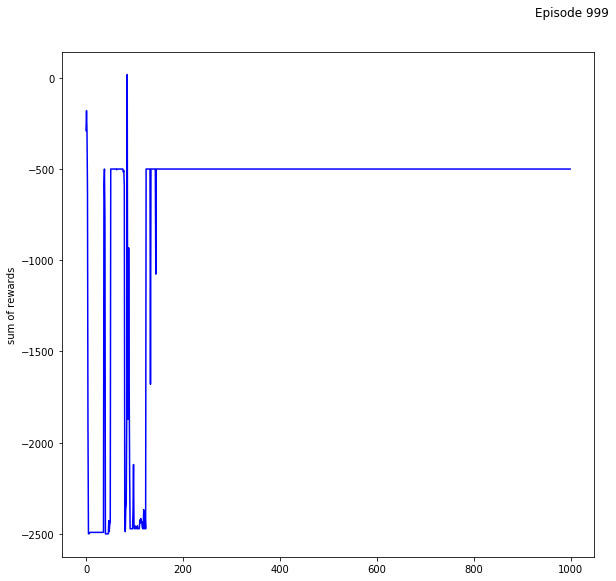

In [21]:
tf.reset_default_graph()

policy = Policy(env)
value = Value(env)

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    rf_baseline(policy, value, env, 1000, [0,0])

### AC with NN approx

In [27]:
def ac_nn(policy, value, env, n_episodes, start):
    rtrace = []
    gamma = .99
    fig = plt.figure(figsize=(16, 16))
    
    for i in range(n_episodes):
        rewards = []
        
        env.init(start)
        state = env.get_cur_state()
        j = 0
        I = 1
        for j in range(500):
            action_prob = policy.predict(encoding(state))
#             print(np.arange(action_prob.shape[1]))
            action = np.random.choice(np.arange(action_prob.shape[1]), p= action_prob[0])
            reward = env.next(action)
            rewards.append(reward)
            
            curr_value = value.predict(encoding(state))
            next_state = env.get_cur_state()
            next_value = value.predict(encoding(next_state))
            
            total = reward + gamma * next_value 
            delta = total - curr_value
            
            value.update(encoding(state), total)
            policy.update(encoding(state), I * delta, action)
            
            
            if env.is_goal():
                print(i)
                break
            I = gamma * I
            state = next_state  
            
        rtrace.append(np.sum(rewards))
        
        last_plot = (i == n_episodes-1)

        if i % 10 == 0 or last_plot:
            plt.clf()
            fig.add_subplot(221)
            plt.plot(rtrace, "b-")
            plt.ylabel("sum of rewards")

    #         fig.add_subplot(222)
    #         plt.plot(etrace, "-")
    #         plt.ylabel("p(random action), $\epsilon$")


            plt.suptitle(''.join(["Episode ",str(i)]))
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.draw()

            ipd.clear_output(wait=True)
            ipd.display(fig)
        ipd.clear_output(wait=True)
            
        

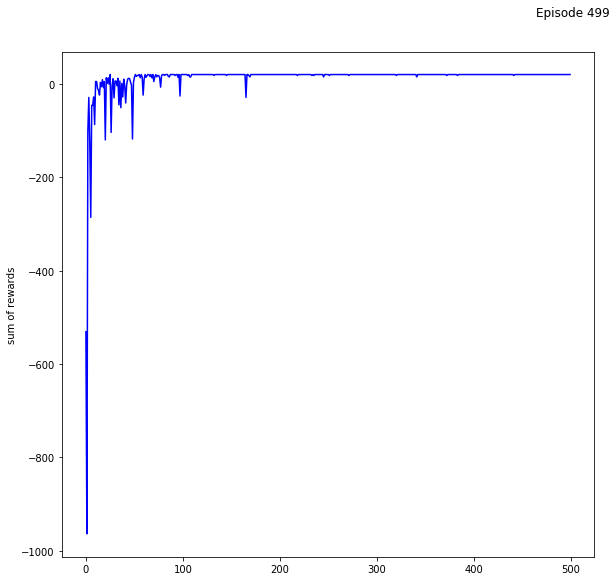

In [28]:
tf.reset_default_graph()

policy_ac = Policy(env)
value_ac = Value(env)

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    ac_nn(policy_ac, value_ac, env, 500, [0,0])

### References:
https://docs.w3cub.com/tensorflow~python/tf/contrib/layers/fully_connected/